In [1]:
# from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

In [2]:
from env import host, user, password

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

In [3]:
url = get_db_url("grocery_db")

sql = '''
select * from grocery_customers
'''

df = pd.read_sql(sql,url, index_col="customer_id")

In [4]:
df

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867


In [5]:
# Cluster on all or a selected subset of features
grocery_frozen_fresh = df[['Grocery', 'Frozen', 'Fresh']]

In [6]:
grocery_frozen_fresh

,Grocery,Frozen,Fresh
customer_id,,,
0,7561,214,12669
1,9568,1762,7057
2,7684,2405,6353
3,4221,6404,13265
4,7198,3915,22615
...,...,...,...
435,16027,13135,29703
436,764,4510,39228
437,30243,437,14531


### Use MinMaxScaler to scale the newly created dataframe.

In [7]:
# Create the scaler object.
scaler = MinMaxScaler()

# Fit the scaler object on the data from grocery_milk_fresh dataframe.
scaler.fit(grocery_frozen_fresh)

# Use the fitted scaler object.
grocery_frozen_fresh = scaler.transform(grocery_frozen_fresh)

In [13]:
grocery_frozen_fresh

array([[0.08146416, 0.0031063 , 0.11294004],
       [0.10309667, 0.02854842, 0.06289903],
       [0.08278992, 0.03911643, 0.05662161],
       ...,
       [0.32594285, 0.00677142, 0.1295431 ],
       [0.02402535, 0.01664914, 0.091727  ],
       [0.02702178, 0.00065742, 0.02482434]])

In [36]:
# Unpack the values of grocery_frozen_fresh and store into variables.
x,y,z = zip(*grocery_frozen_fresh)

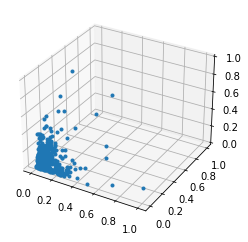

In [40]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x, y, z, '.')
plt.show()

# Takeaways
* I am trying to understand what is going on code-wise when using the DBSCAN object.
* The MinMaxScaler is fit on a specifically shaped array (ex. 2x3, 3x3), then it is uses the values within the array to scale them.
* I took those scaled values and stored them into three different variables. I found an intersting tool called 'zip'. It takes an array and 'unpacks' it. It separates the values into columns to be stored or worked on.
* The DBSCAN object then uses those data points to work it's magic and cluster the data according to hyperparameters set by the user.

### Construct a DBSCAN object that requires a minimum of 20 data points in a neighborhood of radius 0.1 to be considered a core point.

In [14]:
# Create the DBSCAN object.
dbsc = DBSCAN(eps = .10, min_samples = 20)

# Fit the DBSCAN object on the grocery-milk-fresh
dbsc.fit(grocery_frozen_fresh)

DBSCAN(eps=0.1, min_samples=20)

In [41]:
# Add the scaled dataframe back to the original dataframe.
columns = ['Grocery','Frozen','Fresh']
scaled_columns = ['Scaled_' + column for column in columns]

# Create a copy of the original dataframe for a quick and easy restart.
original_df = df.copy()

# Create a dataframe containing the scaled values.
scaled_df = pd.DataFrame(grocery_frozen_fresh, columns=scaled_columns)

# Merge the scaled dataframe to the original dataframe.
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])

In [42]:
df

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Grocery,Scaled_Frozen,Scaled_Fresh
0,2,3,12669,9656,7561,214,2674,1338,0.081464,0.003106,0.112940
1,2,3,7057,9810,9568,1762,3293,1776,0.103097,0.028548,0.062899
2,2,3,6353,8808,7684,2405,3516,7844,0.082790,0.039116,0.056622
3,1,3,13265,1196,4221,6404,507,1788,0.045464,0.104842,0.118254
4,2,3,22615,5410,7198,3915,1777,5185,0.077552,0.063934,0.201626
...,...,...,...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204,0.172715,0.215469,0.264829
436,1,3,39228,1431,764,4510,93,2346,0.008202,0.073713,0.349761
437,2,3,14531,15488,30243,437,14841,1867,0.325943,0.006771,0.129543
438,1,3,10290,1981,2232,1038,168,2125,0.024025,0.016649,0.091727


### Create a new column that holds the values returned from DBSCAN

In [44]:
df['cluster_labels'] = dbsc.labels_

In [45]:
df.cluster_labels.value_counts()

 0    415
-1     25
Name: cluster_labels, dtype: int64

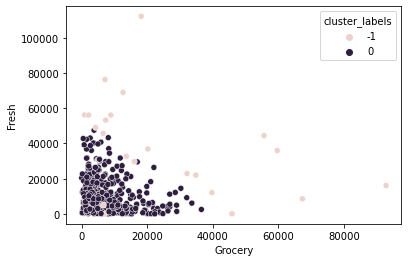

In [46]:
sns.scatterplot(df.Grocery, df.Fresh, hue=df.cluster_labels);

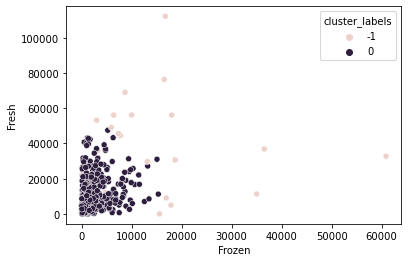

In [47]:
sns.scatterplot(df.Frozen, df.Fresh, hue=df.cluster_labels);

Text(0.5, 0, 'Grocery')

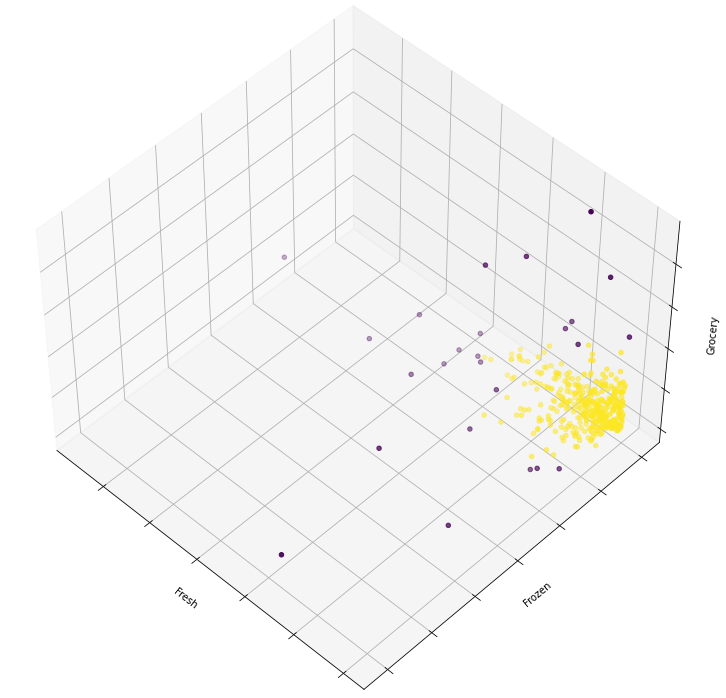

In [48]:
fig = plt.figure(1, figsize=(10,10))
ax = Axes3D(fig, rect=[0,0,.95,1], elev=48, azim=134)

# plot the points
ax.scatter(df.Fresh, df.Frozen, df.Grocery, c=df.cluster_labels)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Fresh')
ax.set_ylabel('Frozen')
ax.set_zlabel('Grocery')